In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import random
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms as T
from timm.data.random_erasing import RandomErasing
from torchvision.utils import make_grid
from tqdm.auto import tqdm

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
PATH = os.getcwd()

PATH = Path(os.path.join(PATH, "data/"))

os.makedirs(PATH, exist_ok=True)
print(PATH)

/home/stud1901/image_restoration/data


In [4]:
class CelebDataset(torch.utils.data.Dataset):
    def __init__(self, img_size:int = 256): 
        self.filenames = list(glob(str(PATH/"images/clean/*.jpg")))#[:12800]
        self.target_size = img_size  
        self.erase = T.RandomErasing(p=1.0, scale=(0.02, 0.22))
        self.transforms = T.Compose([
            T.Resize((self.target_size, self.target_size)),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = self.transforms(image)
        image = image / 255.0
        real  = image.clone()
        condition = self.erase(image)
        return image, condition

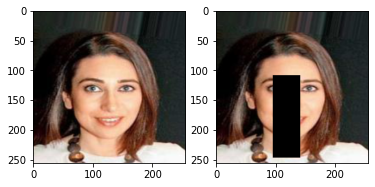

In [5]:
ds = CelebDataset(256)
n = random.choice(range(len(ds)))

image, condition = ds[n]

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(image.permute(1, 2, 0).cpu().numpy() * 255.0)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(condition.permute(1, 2, 0).cpu().numpy() * 255.0)

plt.show()

## Model

In the first part of U-Net shaped network the layer size decreases, we create a `DownSampleConv` module for this. This module will contain the unit block that we just created `ConvBlock`.

In [6]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

Now in the second part the network expands and so we create `UpSampleConv`

In [7]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

Now the basic blocks of the Pix2Pix generated is created, we create the generator module. Generator is formed of expanding and contracting layers.
The first part network contracts and then expands again, i.e. first we have encoder block and then decoder block.
Below is the encoder-decoder of U-Net network configuration from official paper. Here `C` denotes the unit block that we created `ConvBlock` and `D` denotes `Drop Out` with value _0.5_.
In the decoder, the output tensors from `n-i` layer of encoder concatenates with `i` layer of the decoder. Also the first three blocks of the decoder has drop out layers.

```
Encoder:  C64-C128-C256-C512-C512-C512-C512-C512

Decoder:  CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
```

In [8]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        x = self.final_conv(x)
        return self.tanh(x)

### Discriminator
A discriminator is a ConvNet which learns to classify images into discrete labels. In GANs, discriminators learns to predict whether the given image is real or fake.
PatchGAN is the discriminator used for Pix2Pix. Its architecture is different from a typical image classification ConvNet because of the output layer size. In convnets output layer size is equal to the number of classes while in PatchGAN output layer size is a 2D matrix.

In [9]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

## Loss functions

Loss function used in Pix2Pix are `Adversarial loss` and  `Reconstruction loss`. Adversarial loss is used to penalize the generator to predict more realistic images. In conditional GANs, generators job is not only to produce realistic image but also to be near the ground truth output. Reconstruction Loss helps network to produce the realistic image near the conditional image.


```python
adversarial_loss = nn.BCEWithLogitsLoss()

reconstruction_loss = nn.L1Loss()
```

In [10]:
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
def display_progress(cond, fake, real, figsize=(10,5)):
    """Utility functions to display progress"""
    cond = cond.detach().data.cpu().float().permute(1, 2, 0).numpy()
    fake = fake.detach().data.cpu().float().permute(1, 2, 0).numpy()
    real = real.detach().data.cpu().float().permute(1, 2, 0).numpy()
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    
    ax[0].imshow(cond * 255.0)
    ax[0].set_title('Condition')
    
    ax[1].imshow(real * 255.0)
    ax[1].set_title('Real')
    
    ax[2].imshow(fake * 255.0)
    ax[2].set_title('Generated')
    
    plt.show()

In [11]:
class Pix2Pix(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200, display_step=25):

        super().__init__()
        self.save_hyperparameters()
        
        self.display_step = display_step
        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt  = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch

        loss = None
        
        if optimizer_idx == 0:
            loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', loss)
        
        elif optimizer_idx == 1:
            loss = self._gen_step(real, condition)
            self.log('Generator Loss', loss)
        
        if self.current_epoch%self.display_step==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.gen(condition).detach()
            try:
                display_progress(condition[0], fake[0], real[0])
            except Exception as e:
                pass
        
        return loss

Now that the network is implemented now we are ready to train. You can also modify the dataloader and train on custom dataset.

In [13]:
# Configurations taken from original paper

adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 25

display_step = 2
batch_size = 128
lr = 0.0002
target_size = 256
device = 'cuda'

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 54.4 M
1 | patch_gan             | PatchGAN          | 2.8 M 
2 | adversarial_criterion | BCEWithLogitsLoss | 0     
3 | recon_criterion       | L1Loss            | 0     
------------------------------------------------------------
57.2 M    Trainable params
0         Non-trainable params
57.2 M    Total params
228.713   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


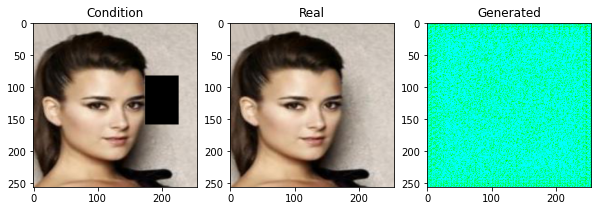

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


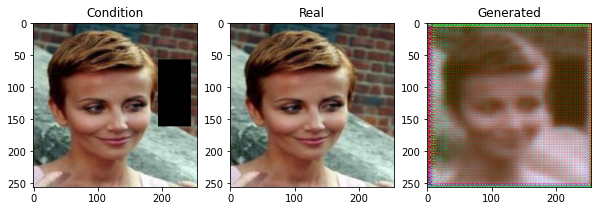

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


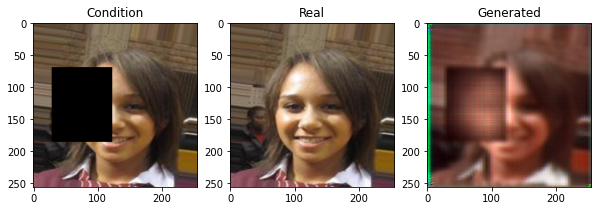

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


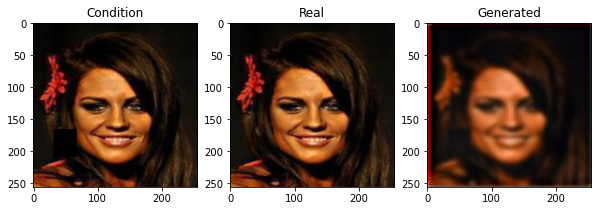

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


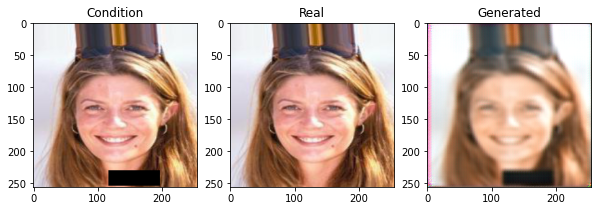

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


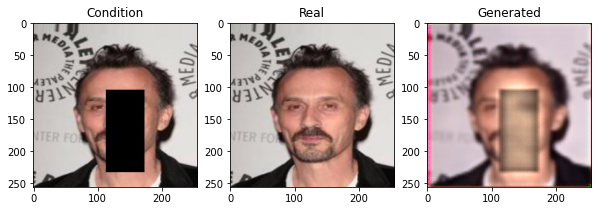

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


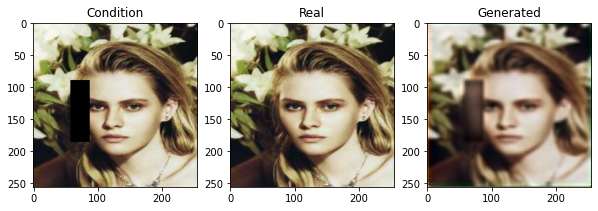

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


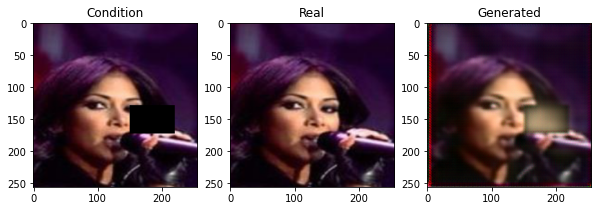

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


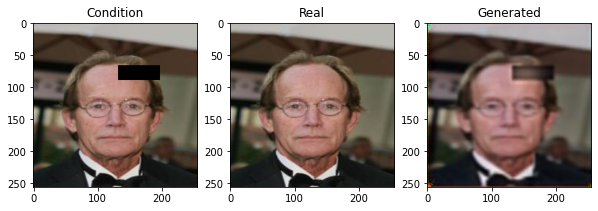

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


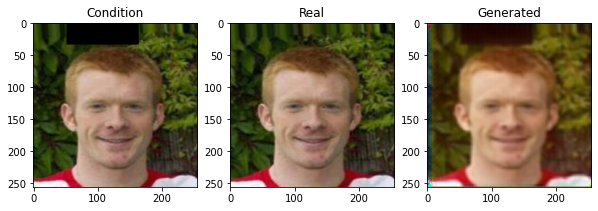

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


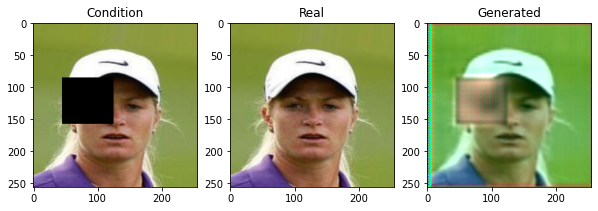

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


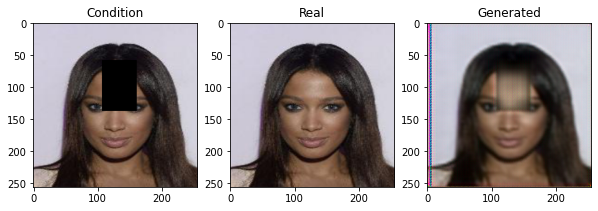

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


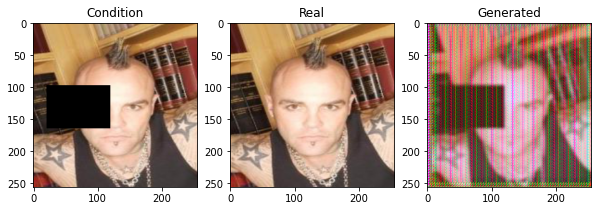

/home/stud1901/miniconda3/envs/image_restoration/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [14]:
dataset = CelebDataset(img_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

pix2pix = Pix2Pix(3, 3, learning_rate=lr, lambda_recon=lambda_recon, display_step=display_step)
trainer = pl.Trainer(
    logger=[pl.loggers.CSVLogger(save_dir='./pix2pix/')],
    callbacks=[pl.callbacks.ModelCheckpoint(dirpath='./pix2pix/')], 
    max_epochs=20, 
    gpus=1, 
    precision=16
)
trainer.fit(pix2pix, dataloader)

## Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


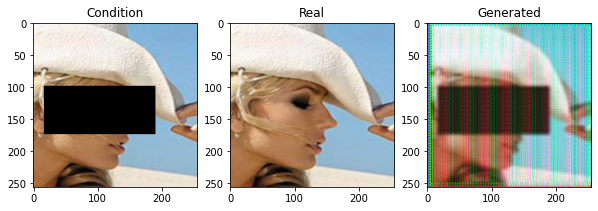

In [18]:
real, condition = next(iter(dataloader))
pix2pix.cuda()
fake = pix2pix.gen(condition.cuda()).detach()
fake = fake[0]
real = real[0]
display_progress(condition[0], fake, real)